# Overview
In this notebook, I consider the impact of dropping different columns from one-hot-encoded categorical groups when preparing data for Ordinary Least Squares multiple linear regression models.

My initial goal was to answer the following questions:
>- Does it matter which column we drop? In other words, will this choice affect the model's results?
>- If it does matter, how should data scientists select the appropriate column to drop?

My hypothesis was that it could matter, and that in some scenarios it would be more appropriate to drop the column that best represents the category that best represents the average of the target. To test this, I generated a dataset including categorical variables that had average values, and used them to generate target values. I then tested different models on the same data, comparing model coefficients and accuracy when dropping no columns, the first (minimum) column, and the column representing the average.

My analysis reveals that **while the column dropped does not appear to affect an OLS linear regression model's predictive accuracy, it can have a significant impact on the interpretability of the model's coefficients**. 

Data scientists preparing an Ordinary Least Squares multiple linear regression model should carefully consider which columns they drop from each category if their goals for analysis include: 
- Ranking standardized coefficients to infer relative magnitude or importance of predictors' impacts on the target variable (i.e. "Does square footage or the number of bedrooms add more to a home's sale price?")
- An accurate understanding of how a unit change of predictor variable impacts the target (i.e. "What is the average increase in home sale price for each square foot of living space added?")
- Explaining either of the above results to non-technical stakeholders.

Arbitrarily dropping the first column without considering what it represents can make it difficult to interpret the model coefficients not only with accuracy, but also in a way that will be intuitive for non-technical stakeholders. 

**Instead of relying on the convention of dropping the first column, data scientists should consider dropping columns that naturally represent logical baseline reference points, from which the model will assume all included predictor variables to deviate.** In some cases a minimum value may be appropriate, in other cases an average value may be appropriate, and in still others the appropriate reference category may depend entirely on the goal of the analysis. 

# Background
## What is one-hot encoding?
When preparing data for an Ordinary Least Squares linear regression model, it is necessary to dummy, or one-hot encode (OHE), categorical variables into separate columns to represent the non-numerical values as numbers. A categorical variable which represents gender, for instance, will be transformed from a single column:

|Gender|
|---|
|M|
|M|
|F|
|F|
|NB|

into multiple one-hot encoded columns, so named since a value of 1 represents membership in that category with the rest of the category columns being filled with zeros:

|Gender_male|Gender_female|Gender_nonbinary|
|---|---|---|
|1|0|0|
|1|0|0|
|0|1|0|
|0|1|0|
|0|0|1|

## Why drop any columns at all?
When learning about linear regression, students of data science are taught to drop one column from each categorical variable group to act as the reference category, and to avoid the "Dummy Variable Trap:" perfect multicollinearity between the predictors. 

In our example, we could drop Female, Male, or NonBinary and leave the other two columns in our model.

As [this article illustrates](https://inmachineswetrust.com/posts/drop-first-columns/) it would not be possible to solve the OLS problem at all using linear algebra if we didn't drop a column, since we would have a singular matrix. Although both scikit-learn and statsmodels libraries use a different algorithm to solve OLS, and so technically *can* generate models if we don't drop a column from each category, it's still considered best practice to do so. In my experiment, I included models with no columns dropped to illustrate the strange results.

If the dataset contains multiple categorical variables, one column should be dropped from each group of resulting columns. Throughout this notebook, I will discuss dropping 'a column,' which should be understood to mean one column from each categorical variable's group of one-hot encoded columns.

## Arbitrarily dropping 'first'
Python libraries such as Pandas and sckikit-learn have parameters built in to their one-hot-encoding methods which allow us to drop a column from each categorical group. A common approach is to drop first, meaning whichever column represents the category value name that comes first alpha-numerically in the set. In our gender example, the first column would be Female since F comes before M and N. 

In fact, dropping first is so common that both [Pandas](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) and [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) have handy constants you can use to do this so you don't have to figure out the first category.

As a student of data science, it struck me as odd that we should be encouraged to arbitrarily drop the column whose categorical value happens to come first alpha-numerically. 
> If it truly doesn't matter which column is dropped, then why not select one at random, as we could easily ask a computer to do for us?

>If it does matter, does it really make sense to assume the first category is best suited? Is this simply for convenience, or is there a logical reason?

## Experiment Overview
To attempt to answer these questions, in this notebook I create an experimental housing data set for which I have expected results, and test the effect of dropping different columns from the data set before modeling.

My hypothesis is that dropping the first column will be problematic when  the first column does not represent either: 1. a logical baseline starting point from which to measure effect size, or 2. an effect of zero.

To test this, I'll specifically engineer categorical variables in my test data set where one category represents the average with an effect close to 0, and the first category represents a negative impact on the target.

I'm interested in comparing the model results in three different ways:
1. Predictive accuracy
2. Interpretability - Accurate ranking of standardized coefficients
3. Interpretability - Accurate and intuitive unit coefficients

# Create Experimental Data Set

I'll create an experimental data set based on home characteristics and sales, where the linear regression model would be trying to predict a home's eventual sale price.

I'll create the following variables:
- **Square Feet of Living Space**: a continuous variable
- **Zip Code**: a categorical variable with a large number of categories (70)
- **Condition**, a categorical variable with a small number of variables (5)
- **Day of the Week (DOTW)**: a capricious variable that will contribute to the price without any particular pattern. I will be able to exclude this from my model to reduce the variability in the target that the model should be able to explain, which will make it somewhat more realistic.

I'll randomly generate the multiplier coefficients for categorical variables based on a normal distribution, and assign them to the categories such that the average category adds very little to the target price, and the 'first' category is the lowest, but actually has a negative effect. 

In [196]:
import numpy as np
np.set_printoptions(precision=3, suppress=True)

import pandas as pd
pd.options.display.float_format = '{:.2f}'.format

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#FFFFFF'
matplotlib.rcParams['axes.facecolor'] = '#FFFFFF'
matplotlib.rcParams['savefig.facecolor'] = '#FFFFFF'

from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

import linregtools

%autoreload 2

## Sq Ft

In [197]:
# Generate sq ft

# Set random seed for reproducability
np.random.seed(5)
df = pd.DataFrame(((np.random.randn(20000)) + 4) * 700, columns=['sqft'])

print(df.head())
print(f"Mean sq ft: {np.mean(df)}")
print(f"Median sq ft: {np.median(df)}")

     sqft
0 3108.86
1 2568.39
2 4501.54
3 2623.54
4 2876.73
Mean sq ft: sqft   2801.13
dtype: float64
Median sq ft: 2803.5581213839223


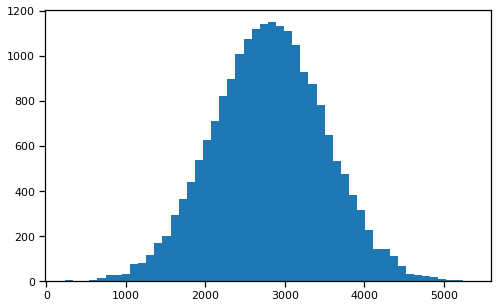

In [198]:
# Plot the sq ft values to confirm their distribution
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(df['sqft'], bins=50);

## Zip Codes

In [199]:
# Next we'll generate a set of 70 fake zip codes

# Set random seed for reproducability
np.random.seed(5)

zips = np.round(np.random.randn(150),2)
zips = (np.unique(abs(zips)) * 100) + 30000
zips = np.unique(zips)[:70]
np.random.shuffle(zips)

print(zips[:5])
print(f"Unique zip codes: {len(np.unique(zips))}")

[30061. 30043. 30106. 30114. 30089.]
Unique zip codes: 70


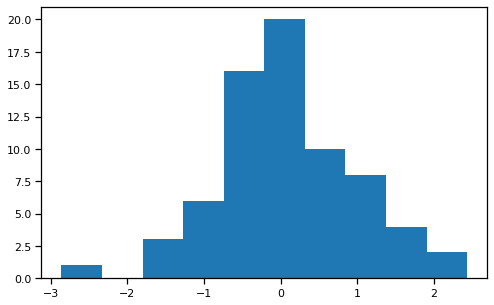

In [200]:
# And assign a random multiplier for price to each zip code.

# Set random seed for reproducability
np.random.seed(5)
zips_x = np.random.randn(70)

# check distribution for zipcode multipliers
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(zips_x);

In [201]:
# combine zipcodes with their multipliers
zips = np.concatenate((zips.reshape(len(zips), 1), 
                       zips_x.reshape(len(zips_x), 1)), axis=1)

# Sort zips so the first will have the lowest multiplier
zips.sort(axis=0)
print(zips[:5])
print(zips[-5:])

[[30000.       -2.86 ]
 [30001.       -1.665]
 [30002.       -1.511]
 [30005.       -1.311]
 [30006.       -1.193]]
[[30106.        1.562]
 [30114.        1.582]
 [30115.        1.857]
 [30116.        2.26 ]
 [30117.        2.431]]


In [202]:
# Turn array into a dataframe and convert zipcode to string
df_zips = pd.DataFrame(zips, columns=['zip','zip_multi'])

df_zips['zip'] = df_zips['zip'].astype(str, copy=False)
df_zips['zip'] = df_zips['zip'].map(lambda x: x[:5])

df_zips.head()

,zip,zip_multi
0,30000,-2.86
1,30001,-1.66
2,30002,-1.51
3,30005,-1.31
4,30006,-1.19


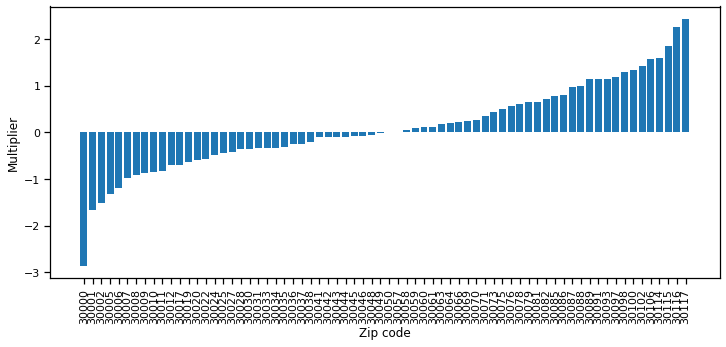

In [203]:
# show distribution of multipliers across zips
fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(x=df_zips['zip'], height=df_zips['zip_multi'])
ax.set_xlabel('Zip code')

ax.tick_params(axis='x', which='major', rotation=90)

ax.set_ylabel('Multiplier');

When I test dropping the first category of zips (30000), it will represent a zip code with a negative multiplier on the extreme low end, which will not be very representative of the population average, and also will not have an effect of 0.

I'm going to assign zip codes randomly to groups of houses so zip code will be truly independent of sq ft.

In [204]:
# Assign zip codes and multipliers randomly to houses
df = linregtools.assign_cats(df_zips, df, seed=5)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sqft       20000 non-null  float64
 1   zip        20000 non-null  object 
 2   zip_multi  20000 non-null  float64
dtypes: float64(2), object(1)
memory usage: 468.9+ KB


I want the first zip code that we drop to not only be an outlier in terms of the size of its multiplier, but also in terms of the number of houses in that zip. I want it to be a smaller group size.

In [205]:
# let's check how many houses we randomly assigned to our first zip code 30000
len(df.loc[df['zip'] == '30000'])

349

In [206]:
# how does that compare to the rest?
df['zip'].value_counts(ascending=True)

30043    148
30012    150
30006    151
30079    157
30076    159
        ... 
30044    399
30050    401
30081    408
30069    410
30059    417
Name: zip, Length: 70, dtype: int64

In [207]:
# let's move over a chunk of houses from 30000 to 30043 so 30000 is the smallest
df.loc[df['zip'] == '30043']

,sqft,zip,zip_multi
259,2775.17,30043,-0.10
388,1781.71,30043,-0.10
393,2983.08,30043,-0.10
528,2310.34,30043,-0.10
628,3642.61,30043,-0.10
...,...,...,...
19183,2635.77,30043,-0.10
19334,4274.52,30043,-0.10
19660,3283.43,30043,-0.10
19935,2504.94,30043,-0.10


In [208]:
switch = df.loc[df['zip'] == '30000'][149:].index

df.loc[switch, ['zip']] = '30043'
df.loc[switch, ['zip_multi']] = -0.101068

len(df.loc[df['zip'] == '30000'])

149

## House Condition
This will simulate a rating for the house representing how well it has been maintained, etc. This will be ranked, so houses in below average condition will fetch lower prices, and houses with above average condition will fetch higher prices.

Most houses will receive an average condition, which will have a multiplier of 0. The condition that comes first, 1_poor, will decrease the price.

In [209]:
# Create condition categories and multipliers
conds = [['1_poor', -1.25]
        ,['2_below average', -0.25]
        ,['3_average', 0]
        ,['4_above average', 0.1]
        ,['5_excellent', 0.3]]

df_conds = pd.DataFrame(conds, columns=['condition','condition_multi'])
df_conds.head()

,condition,condition_multi
0,1_poor,-1.25
1,2_below average,-0.25
2,3_average,0.00
3,4_above average,0.10
4,5_excellent,0.30


Now I'll apply conditions to houses using a dictionary to map the proportion of total houses to be assigned to each category. 

The majority (70%) will be assigned to the Average category, which I think is fairly realistic. 10% each will be Below Average and Above Average, and 5% each will be Poor and Excellent. 

In [210]:
# create a dictionary to pass with the conditions to make sure the
# average gets applied to the majority of houses
prop_map = {'1_poor':0.05, '2_below average':0.1, '3_average':0.7,
             '4_above average':0.1, '5_excellent':0.05}

df = linregtools.assign_cats(df_conds, df, prop_map, 5)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sqft             20000 non-null  float64
 1   zip              20000 non-null  object 
 2   zip_multi        20000 non-null  float64
 3   condition        20000 non-null  object 
 4   condition_multi  20000 non-null  float64
dtypes: float64(3), object(2)
memory usage: 781.4+ KB


In [211]:
df['condition'].value_counts()

3_average          14000
4_above average     2000
2_below average     2000
1_poor              1000
5_excellent         1000
Name: condition, dtype: int64

## Confounding variable "Day of the week"
The "day of the week" variable will represent the day of the week when the buyer viewed the home. 

This isn't intended to be realistic (I don't have reason to believe that the day of the week when someone viewed a home would actually affect its price).

It is intended as a confounding variable that we will include in our calculations to generate price, but that we can exclude from the model to simulate a real-world scenario where price variability cannot be 100% explained by the data we have available. 

Where the Condition and Zip code multipliers were crafted carefully to have average categories that made sense, DOTW multipliers were just made up, and assigned randomly to houses.

In [212]:
dotw = [['Monday', -0.2]
       ,['Tuesday', 0.3]
       ,['Wednesday', -0.1]
       ,['Thursday', 0.25]
       ,['Friday', -0.45]
       ,['Saturday', 0.2]
       ,['Sunday', 0.1]]

df_dotw = pd.DataFrame(dotw, columns=['dotw','dotw_multi'])
df_dotw

,dotw,dotw_multi
0,Monday,-0.20
1,Tuesday,0.30
2,Wednesday,-0.10
3,Thursday,0.25
4,Friday,-0.45
5,Saturday,0.20
6,Sunday,0.10


In [213]:
# assign dotw categories randomly to houses
df = linregtools.assign_cats(df_dotw, df, seed=5)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sqft             20000 non-null  float64
 1   zip              20000 non-null  object 
 2   zip_multi        20000 non-null  float64
 3   condition        20000 non-null  object 
 4   condition_multi  20000 non-null  float64
 5   dotw             20000 non-null  object 
 6   dotw_multi       20000 non-null  float64
dtypes: float64(4), object(3)
memory usage: 1.1+ MB


In [214]:
df['dotw'].value_counts()

Monday       3682
Tuesday      3153
Wednesday    2852
Sunday       2579
Friday       2578
Saturday     2578
Thursday     2578
Name: dotw, dtype: int64

In [215]:
df['dotw_multi'].describe()

count   20000.00
mean        0.01
std         0.25
min        -0.45
25%        -0.20
50%         0.10
75%         0.25
max         0.30
Name: dotw_multi, dtype: float64

## Calculate Price

Price will be calculated based on the variables I've created, using values in the multiplier columns against a constant. Since some of my multipliers are negative, I needed to choose an appropriate y-intercept and constant for the multipliers, to make sure I didn't end up with negative or way too small home prices. In testing, I ran a few different versions of the function and tuned these to come up with appropriate numbers.

To keep things simple in this experiment, I'm not going to introduce any multicollinearity, although in real housing data this would likely exist. For instance, average price per square feet might be different in different zip codes, and houses in given zip codes may tend to have more or less square feet than others.

- Baseline (y-intercept) of \\$100,000
- Add \\$100 per sq ft
- Apply multipliers based on zip code, condition, and "day of the week". Since my multipliers were randomly chosen from a normal distribution, I'll multiply them by a base multiplier of 50,000 to get a coefficient that will make a difference in price units.

In [216]:
# Calculate price based on variables
def calc_homeprice(row, base=100000, sqft_x=100, base_multi=50000):
    
    # start with base
    price = base
    
    # for categories, we'll use a baseline of 50,000 and apply the mulipliers
    # to that, since we didn't 
    
    # add sqft
    price += (row['sqft'] * sqft_x)
    # add zip
    price += (row['zip_multi'] * base_multi)
    # add condition
    price += (row['condition_multi'] * base_multi)
    # add dotw
    price += (row['dotw_multi'] * base_multi)
    
    return price
    

In [217]:
df['price'] = df.apply(lambda x : calc_homeprice(x), axis=1)
df.describe()

,sqft,zip_multi,condition_multi,dotw_multi,price
count,20000.00,20000.00,20000.00,20000.00,20000.00
mean,2801.13,0.15,-0.06,0.01,385149.01
std,702.16,0.90,0.29,0.25,85800.34
min,232.89,-2.86,-1.25,-0.45,44399.45
25%,2326.61,-0.36,0.00,-0.20,326278.32
50%,2803.56,0.01,0.00,0.10,384711.96
75%,3278.52,0.71,0.00,0.25,442283.45
max,5339.52,2.43,0.30,0.30,691639.81


I'll admit that a 232 sq ft home is pretty small, and a price of \\$44.4k is pretty low, but in general I'm on board with these sq ft and price statistics for our sample data.

### Calculate expected coefficients for variables
It will be important to understand the expected coefficients for each category, so I can assess each model's accuracy.

Since I'm familiar already with how sklearn's OneHotEncoder class will name the categorical columns, I'll name my columns the same so I can easily compare later.

In [218]:
# create a df of expected coefficients, so we can compare to each model's results
cat_cols = ['zip', 'condition', 'dotw']
base_multi = 50000
coefs_dict = {}

for col in cat_cols:
    
    # get series of unique categorical values and their multipliers
    grouped = df.groupby(col, axis=0, )[col + '_multi'].min()
    
    # rename them to be like what we'll get form OHE
    new_names = [col + '_' + label for label in grouped.index]
    dict_names = dict(zip(grouped.index, new_names))
    grouped.rename(index=dict_names, inplace=True)
    
    # multiply by base
    grouped = grouped * base_multi
    
    # convert to dictionary and merge with existing
    coefs_dict.update(grouped.to_dict())
    
coefs_dict['sqft'] = 100
coefs_dict['y-intercept'] = 100000

#df_ex_coefs = pd.DataFrame(coefs_dict.values(), index=coefs_dict.keys(), 
#                           columns=['expected_coef'])
dict_list = [coefs_dict]

df_ex_coefs = pd.DataFrame(dict_list).transpose()
df_ex_coefs.rename(columns={0: 'expected_coef'}, inplace=True)
df_ex_coefs

,expected_coef
zip_30000,-142984.40
zip_30001,-83239.43
zip_30002,-75558.98
zip_30005,-65538.66
zip_30006,-59638.23
...,...
dotw_Thursday,12500.00
dotw_Tuesday,15000.00
dotw_Wednesday,-5000.00
sqft,100.00


The values above are the coefficients we would hope a good model could produce on data in its original units. 

However, it's common to standardize continuous data before modeling, so the units are comparable. We only have one continuous variable, square feet. I'll need to adjust the expected coefficient for the standardized test to be the standard deviation for square feet * the unit coefficient.

I'm going to leave the expected coefficients of the categorical variables for this purpose as-is, since I'm not going to be standardizing them.

In [219]:
df['sqft'].std()

702.1604910205588

In [220]:
# update standardized coefficient for sqft for later comparison
df_ex_coefs_std = df_ex_coefs.copy()
df_ex_coefs_std.loc['sqft', 'expected_coef'] = (df['sqft'].std() * 100)
df_ex_coefs_std.tail()

,expected_coef
dotw_Thursday,12500.00
dotw_Tuesday,15000.00
dotw_Wednesday,-5000.00
sqft,70216.05
y-intercept,100000.00


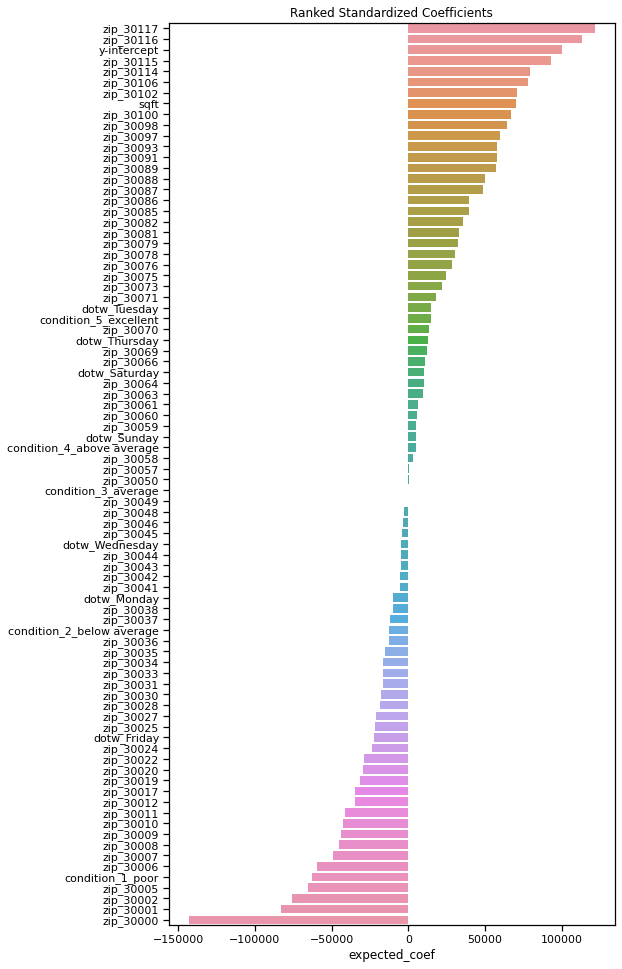

In [221]:
sns.set_context('notebook')

# Get list of categories sorted in alpha order
order = df_ex_coefs_std['expected_coef'].sort_values(ascending=False).index

# plot standardized coefficients in order
h = len(df_ex_coefs_std)
fig, ax = plt.subplots(figsize=(8, (h*0.15)+4))

sns.barplot(data=df_ex_coefs_std, orient='h', x='expected_coef', 
            y=df_ex_coefs_std.index, ax=ax, order=order)
ax.set_title('Ranked Standardized Coefficients');

Great, so I see that a few zip codes actually affect price more than square feet, but square feet should be in the top 10.

### Determine average categories

I specifically engineered the '3_average' condition category to be the average, but I need to figure out what the average zip code and day of the week categories are.

Although I could figure this out by taking the category with the multiplier closest to 0, that approach is only possible if I know the coefficients, which I wouldn't in a real life scenario. 

I'm going to decide average category by comparing the mean price within each category to the overall mean price. And I'll check that condition works this way too.

In [222]:
# get overall mean price
mean_price = df.price.mean()
print(f'Mean price overall: {mean_price}')
print('\n')

# get mean price for each condition
means_per_cond = df.groupby('condition')['price'].mean()

closest = (np.abs(means_per_cond - mean_price)).argmin()
print(f'Condition with closest mean: {means_per_cond.index[closest]}')
print(f'Mean: {means_per_cond[closest]}')
print('\n')

# get mean price for each zip code
means_per_zip = df.groupby('zip')['price'].mean()

closest = (np.abs(means_per_zip - mean_price)).argmin()
print(f'Zip code with closest mean: {means_per_zip.index[closest]}')
print(f'Mean: {means_per_zip[closest]}')
print('\n')

# get mean price for dotws
means_per_dotw = df.groupby('dotw')['price'].mean()

closest = (np.abs(means_per_dotw - mean_price)).argmin()
print(f'Dotw with closest mean: {means_per_dotw.index[closest]}')
print(f'Mean: {means_per_dotw[closest]}')

Mean price overall: 385149.01030842564


Condition with closest mean: 3_average
Mean: 387743.88197591953


Zip code with closest mean: 30066
Mean: 385371.5980158639


Dotw with closest mean: Wednesday
Mean: 383203.33047588903


OK, so my average categories are going to be a condition of 3, zip code 30066, and 'day of the week' of Wednesday.

These are the categories I will test dropped from the model instead of the first. My hypothesis is that dropping them will provide more accurate coefficients.

In [223]:
avg_cats = ['condition_3_average', 'zip_30066', 'dotw_Wednesday']
avg_cats

['condition_3_average', 'zip_30066', 'dotw_Wednesday']

# Explore Data
Luckily, since we generated this data from scratch, we don't have to worry about data cleaning.

But let's check out the distributions of each variable.

---------------------------------------------------------------------------
Exploring column: price
---------------------------------------------------------------------------
---------------------------------------------------------------------------
df.describe() for continuous data: price
---------------------------------------------------------------------------
count    20000.00
mean    385149.01
std      85800.34
min      44399.45
25%     326278.32
50%     384711.96
75%     442283.45
max     691639.81
Name: price, dtype: float64


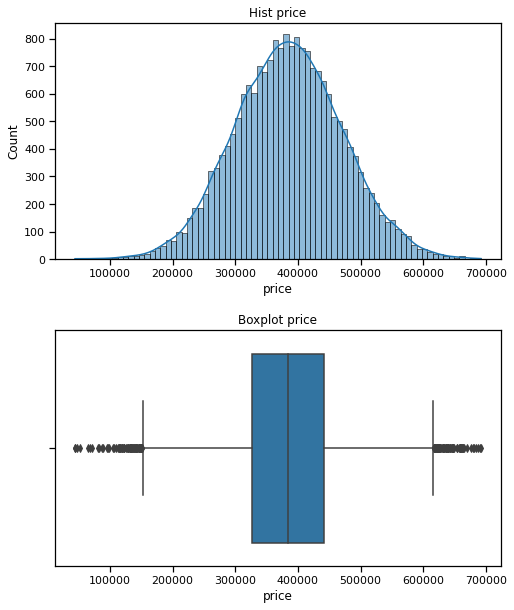


Data IS normal with p-statistic = 0.23641685412016694



,col_name,corr_target,assumed_var_type,omnibus_k2,omnibus_pstat,is_normal,uniques,mean,median
0,price,1.00,continuous,2.88,0.24,True,nan,385149.01,384711.96


In [224]:
sns.set_context('notebook')
linregtools.explore_data('price', df, 'price', plot_v_target=False)

Price, our target variable, is normal. There are some outliers, but we're not going to worry about these for now.

---------------------------------------------------------------------------
Exploring column: sqft
---------------------------------------------------------------------------
---------------------------------------------------------------------------
df.describe() for continuous data: sqft
---------------------------------------------------------------------------
count   20000.00
mean     2801.13
std       702.16
min       232.89
25%      2326.61
50%      2803.56
75%      3278.52
max      5339.52
Name: sqft, dtype: float64


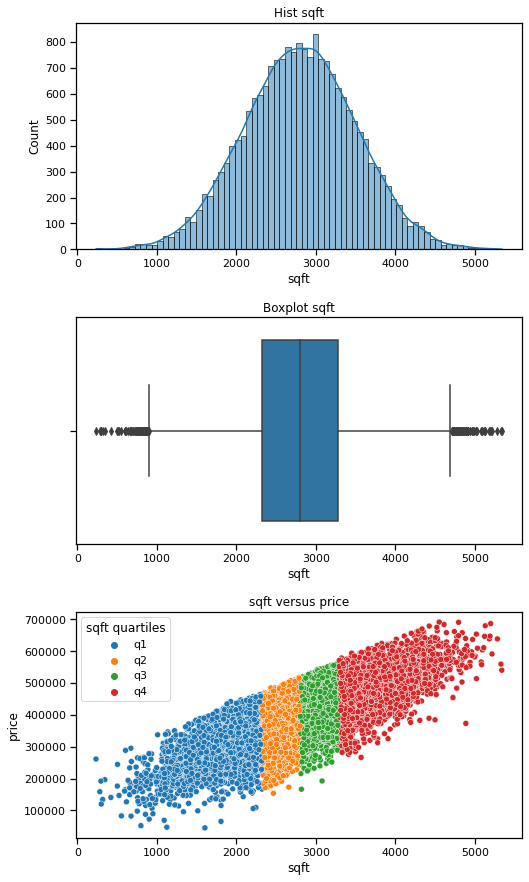


Data IS normal with p-statistic = 0.3749059637869987

---------------------------------------------------------------------------
Exploring column: zip
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Value Counts for categorical data: zip
---------------------------------------------------------------------------
30059    417
30069    410
30081    408
30050    401
30044    399
        ... 
30076    159
30079    157
30006    151
30012    150
30000    149
Name: zip, Length: 70, dtype: int64


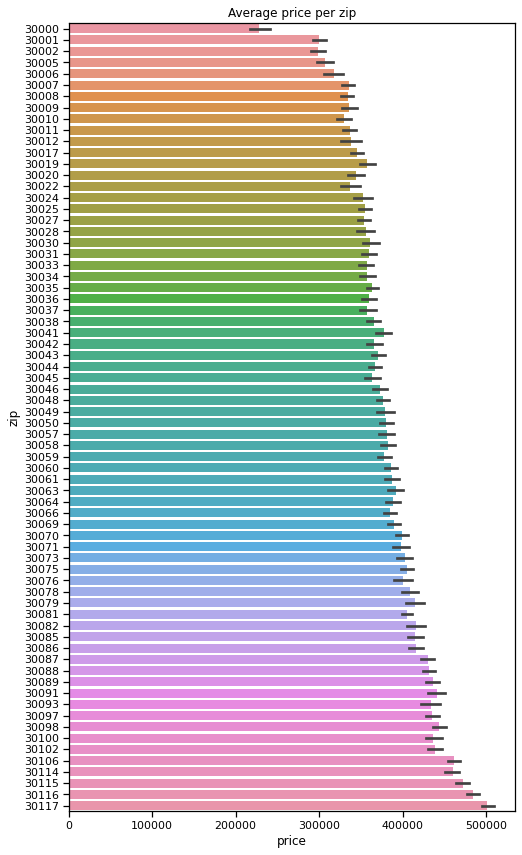

---------------------------------------------------------------------------
Exploring column: condition
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Value Counts for categorical data: condition
---------------------------------------------------------------------------
3_average          14000
4_above average     2000
2_below average     2000
1_poor              1000
5_excellent         1000
Name: condition, dtype: int64


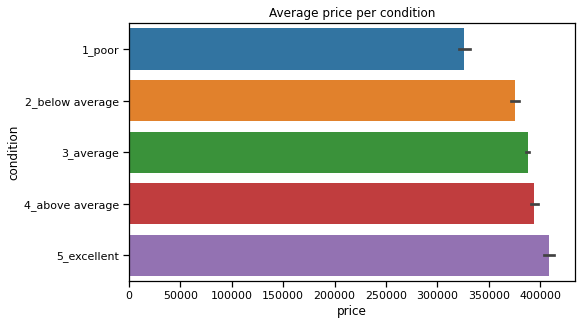

---------------------------------------------------------------------------
Exploring column: dotw
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Value Counts for categorical data: dotw
---------------------------------------------------------------------------
Monday       3682
Tuesday      3153
Wednesday    2852
Sunday       2579
Friday       2578
Saturday     2578
Thursday     2578
Name: dotw, dtype: int64


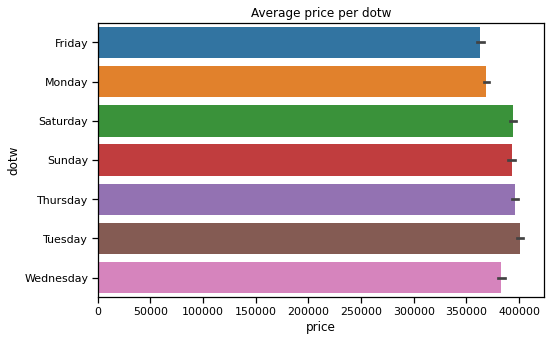

,col_name,corr_target,assumed_var_type,omnibus_k2,omnibus_pstat,is_normal,uniques,mean,median
0,sqft,0.82,continuous,1.96,0.37,True,nan,2801.13,2803.56


In [225]:
ind_vars = ['sqft','zip','condition','dotw']

linregtools.explore_data(ind_vars, df, 'price')

## Summary of Experimental Data
Before we proceed, let's summarize the state of our experimental data:

### Non-Categorical Variables
- We used a baseline price of \\$100,000, so our y-intercept should be 100k.
- We have one continuous independent variable, sq ft, which should have an original unit coefficient of \\$100 per sq ft.

We have three categorical variables: zip, condition, and a confounding variable to add some noise, day of the week (dotw).

### Zip code
- Zip has 70 categories, so a fairly large number. 
- Houses were assigned to zip codes randomly, and in fairly evenly but not totally evenly sized chunks.
- The zip that comes first alphabetically--and will thus be dropped according to convention--is 30000. We have engineered this group to be the smallest (only 149 houses), and with a multiplier (and coefficient) which are the lowest, but are negative instead of being 0.

### Condition
- Condition has only 5 categories, so much fewer than zip codes.
- We purposefully assigned the majority of houses to a condition of *3_average*, and assigned that group a multiplier of 0. 
- Condition scores of 1, 2, 4, and 5 were assigned to fewer houses. The first category, *1_poor* has a multiplier below average and also much fewer houses than average.

### Day of the Week
- We can model both with dotw and without it to see if the category we drop affects the model to a different degree depending on how much of the variability in target the included variables can explain. 
- Dotw was was assigned randomly. The dotw with mean price closest to average for the population is Wednesday, so we'll use that for the average category.


# Modeling

## Map model parameters I want to test

I'm going to run 12 different versions of a model with slightly different parameters for the data.

I'll vary:
- Dropping no categorical variables, dropping the first, and dropping the average. 
    - I'm going to test dropping no categorical variables just to prove that the advice to do so is valid. When regularizing, or with other types of models, we often don't need to drop a category, so I think it's worth proving out that it's necessary at all here.
- Keeping in the 'day of the week' (dotw) variable to naturally allow the model to predict more variation, versus excluding dotw and having it act as a confounding variable. This will help me determine if changing how I drop OHE categories impacts model performance differently depending on how much variability my available predictors can explain.
- Standardizing the data or not. Only the continuous variable, square feet, will be standardized.

In [226]:
# these are the different model parameters I'll loop through
test_models = {1: {'keep_dotw': True, 'cat_drop': None, 'stand': True},
               2: {'keep_dotw': True, 'cat_drop': 'first', 'stand': True},
               3: {'keep_dotw': True, 'cat_drop': 'avg', 'stand': True},
               4: {'keep_dotw': True, 'cat_drop': None, 'stand': False},
               5: {'keep_dotw': True, 'cat_drop': 'first', 'stand': False},
               6: {'keep_dotw': True, 'cat_drop': 'avg', 'stand': False},
               7: {'keep_dotw': False, 'cat_drop': None, 'stand': True},
               8: {'keep_dotw': False, 'cat_drop': 'first', 'stand': True},
               9: {'keep_dotw': False, 'cat_drop': 'avg', 'stand': True},
               10: {'keep_dotw': False, 'cat_drop': None, 'stand': False},
               11: {'keep_dotw': False, 'cat_drop': 'first', 'stand': False},
               12: {'keep_dotw': False, 'cat_drop': 'avg', 'stand': False}}


## Iterate Models and Save Results

In [227]:
# Run through preprocessing and model fitting on the models with different
# parameters, and save results to a dataframe for the coefficients, and 
# a dataframe for statistics related to accuracy

all_cat_cols = ['zip', 'condition', 'dotw']

df_coefs, df_stats = linregtools.iterate_models_sklearn(
    test_models, df, 'price', ['sqft'], all_cat_cols, avg_cats, 
    std_cat=False, random_state=5, verbose=False)

# display results dfs
display(df_coefs)
display(df_stats)

,model_id,y-intercept,sqft,zip_30000,zip_30001,zip_30002,zip_30005,zip_30006,zip_30007,zip_30008,...,condition_3_average,condition_4_above average,condition_5_excellent,dotw_Friday,dotw_Monday,dotw_Saturday,dotw_Sunday,dotw_Thursday,dotw_Tuesday,dotw_Wednesday
0,1,403292679.17,70131.09,127596938.70,127656683.67,127664364.12,127674384.44,127680284.87,127690892.70,127694461.48,...,-184850965.32,-184845965.32,-184835965.32,-345823866.09,-345811366.09,-345791366.09,-345796366.09,-345788866.09,-345786366.09,-345806366.09
1,2,152286.46,70131.09,nan,59744.97,67425.42,77445.74,83346.17,93954.00,97522.78,...,62500.00,67500.00,77500.00,nan,12500.00,32500.00,27500.00,35000.00,37500.00,17500.00
2,3,386333.56,70131.09,-154047.10,-94302.13,-86621.68,-76601.36,-70700.94,-60093.10,-56524.33,...,nan,5000.00,15000.00,-17500.00,-5000.00,15000.00,10000.00,17500.00,20000.00,nan
3,4,94759.26,100.00,-148029.37,-88284.40,-80603.95,-70583.63,-64683.21,-54075.37,-50506.60,...,11000.00,16000.00,26000.00,-23214.29,-10714.29,9285.71,4285.71,11785.71,14285.71,-5714.29
4,5,-127984.40,100.00,nan,59744.97,67425.42,77445.74,83346.17,93954.00,97522.78,...,62500.00,67500.00,77500.00,nan,12500.00,32500.00,27500.00,35000.00,37500.00,17500.00
5,6,106062.71,100.00,-154047.10,-94302.13,-86621.68,-76601.36,-70700.94,-60093.10,-56524.33,...,nan,5000.00,15000.00,-17500.00,-5000.00,15000.00,10000.00,17500.00,20000.00,nan
6,7,-5850953022077331.00,70013.36,2552276557307788.50,2552276557367568.00,2552276557372151.00,2552276557383475.50,2552276557389468.00,2552276557400971.00,2552276557404228.00,...,3298676465008524.00,3298676465013474.00,3298676465023392.50,nan,nan,nan,nan,nan,nan,nan
7,8,172709.01,70013.36,nan,59777.00,64357.82,75681.32,81679.31,93180.00,96439.81,...,66274.11,71227.10,81147.17,nan,nan,nan,nan,nan,nan,nan
8,9,392479.98,70013.36,-153496.85,-93719.86,-89139.03,-77815.53,-71817.55,-60316.86,-57057.04,...,nan,4952.99,14873.06,nan,nan,nan,nan,nan,nan,nan
9,10,-4306854972882.24,99.83,2623659701968.92,2623659761745.92,2623659766326.74,2623659777650.24,2623659783648.22,2623659795148.92,2623659798408.73,...,1683195230096.10,1683195235049.09,1683195244969.15,nan,nan,nan,nan,nan,nan,nan


,model_id,R-sq Train,R-sq Test,RMSE Train,RMSE Test,RSS Train,RSS Test
0,1,1.00,1.00,0.00,0.00,0.03,0.01
1,2,1.00,1.00,0.00,0.00,0.03,0.01
2,3,1.00,1.00,0.00,0.00,0.03,0.01
3,4,1.00,1.00,0.00,0.00,0.03,0.01
4,5,1.00,1.00,0.00,0.00,0.03,0.01
5,6,1.00,1.00,0.00,0.00,0.03,0.01
6,7,0.98,0.98,12521.95,12497.23,2351986821947.16,780904349472.57
7,8,0.98,0.98,12521.94,12497.13,2351985276259.94,780891822514.56
8,9,0.98,0.98,12521.94,12497.13,2351985276259.94,780891822514.56
9,10,0.98,0.98,12521.94,12497.13,2351985276434.91,780891821514.40


# Accuracy Interpretation
In terms of accuracy (the second df), I see that the first 6 models are pretty much the same, and the last 6 models are pretty much the same.

The first 6 models are basically perfect, since I included the dotw variable. The model includes all of the variables that were used to calculate price, so the model appropriately explains 100% of the target variance. We're unlikely to ever come across this scenario in real life, but it's nice to prove that the process works!

Models 7-12 did not include 'day of the week' so that it acted as a confounding variable. It makes sense that the last 6 models would have some errors and not predict 100% of the variability in the target, since they didn't include all the variables that we engineered to affect price.

I don't see any difference in accuracy amongst the models that included the same number of variables, which means varying which categorical column we dropped did not have any impact on prediction accuracy.

# Coefficient Interpretation
In the first df, I see that the coefficients change quite a lot for each model. I don't think I'll be able to eyeball the differences between all 12 models this way, so I'll take some time to single out different groups to compare them.

In [228]:
display(df_coefs)

,model_id,y-intercept,sqft,zip_30000,zip_30001,zip_30002,zip_30005,zip_30006,zip_30007,zip_30008,...,condition_3_average,condition_4_above average,condition_5_excellent,dotw_Friday,dotw_Monday,dotw_Saturday,dotw_Sunday,dotw_Thursday,dotw_Tuesday,dotw_Wednesday
0,1,403292679.17,70131.09,127596938.70,127656683.67,127664364.12,127674384.44,127680284.87,127690892.70,127694461.48,...,-184850965.32,-184845965.32,-184835965.32,-345823866.09,-345811366.09,-345791366.09,-345796366.09,-345788866.09,-345786366.09,-345806366.09
1,2,152286.46,70131.09,nan,59744.97,67425.42,77445.74,83346.17,93954.00,97522.78,...,62500.00,67500.00,77500.00,nan,12500.00,32500.00,27500.00,35000.00,37500.00,17500.00
2,3,386333.56,70131.09,-154047.10,-94302.13,-86621.68,-76601.36,-70700.94,-60093.10,-56524.33,...,nan,5000.00,15000.00,-17500.00,-5000.00,15000.00,10000.00,17500.00,20000.00,nan
3,4,94759.26,100.00,-148029.37,-88284.40,-80603.95,-70583.63,-64683.21,-54075.37,-50506.60,...,11000.00,16000.00,26000.00,-23214.29,-10714.29,9285.71,4285.71,11785.71,14285.71,-5714.29
4,5,-127984.40,100.00,nan,59744.97,67425.42,77445.74,83346.17,93954.00,97522.78,...,62500.00,67500.00,77500.00,nan,12500.00,32500.00,27500.00,35000.00,37500.00,17500.00
5,6,106062.71,100.00,-154047.10,-94302.13,-86621.68,-76601.36,-70700.94,-60093.10,-56524.33,...,nan,5000.00,15000.00,-17500.00,-5000.00,15000.00,10000.00,17500.00,20000.00,nan
6,7,-5850953022077331.00,70013.36,2552276557307788.50,2552276557367568.00,2552276557372151.00,2552276557383475.50,2552276557389468.00,2552276557400971.00,2552276557404228.00,...,3298676465008524.00,3298676465013474.00,3298676465023392.50,nan,nan,nan,nan,nan,nan,nan
7,8,172709.01,70013.36,nan,59777.00,64357.82,75681.32,81679.31,93180.00,96439.81,...,66274.11,71227.10,81147.17,nan,nan,nan,nan,nan,nan,nan
8,9,392479.98,70013.36,-153496.85,-93719.86,-89139.03,-77815.53,-71817.55,-60316.86,-57057.04,...,nan,4952.99,14873.06,nan,nan,nan,nan,nan,nan,nan
9,10,-4306854972882.24,99.83,2623659701968.92,2623659761745.92,2623659766326.74,2623659777650.24,2623659783648.22,2623659795148.92,2623659798408.73,...,1683195230096.10,1683195235049.09,1683195244969.15,nan,nan,nan,nan,nan,nan,nan


## Calculate difference from expected
Since some of these numbers are quite large, it will be useful to calculate the difference between the expected coefficient for each variable, and what each model came up with. 

Since we have a lot of zip codes and it will be difficult to assess the coefficient differences for each zip, I'll also calculate a mean difference and mean absolute difference for each category to simplify my initial interpretation.

In [229]:
avg_diffs = []

std_models = [1, 2, 3, 7, 8, 9]

# loop through models
# Note that this uses the non-standardized expected coefficiens df
# since the standardized one is the same except for sq ft, I adjusted sq ft
# manually
for i in range(1, 13):
    diffs = {'model_id': i}
    
    # get row from df and transpose it
    coefs = df_coefs.loc[df_coefs['model_id'] == i].transpose()
    coefs.drop(labels=['model_id'], inplace=True)
    coefs.rename(columns={i-1:'model'}, inplace=True)
    
    # concatenate with expected coefs so we can subtract where coefs exist
    coefs = pd.concat([coefs, df_ex_coefs], axis=1)
    #print(coefs.head())
    
    # calculate the difference between mode coef and expected
    coefs['diff'] = coefs.apply((lambda x: x[1] - x[0]), axis=1)
    coefs['abs_diff'] = coefs.apply((lambda x: abs(x[1] - x[0])), axis=1)
    
    # get average difference per categorical group
    diffs['y-intercept_diff'] = coefs.at['y-intercept','diff']
    
    # make an expected coefficient adjustment for sq ft for standardized models
    if i in std_models:
        diffs['sqft_diff'] = (df['sqft'].std() * 100) - coefs.at['sqft','model'] 
    else:
        diffs['sqft_diff'] = coefs.at['sqft','diff']
    
    for cat in ['zip', 'condition', 'dotw']:
        diffs[cat + '_meandiff'] = coefs.filter(like=cat, axis=0)['diff'].mean()
        diffs[cat + '_meanabsdiff'] = coefs.filter(like=cat, axis=0)['abs_diff'].mean()
    
    avg_diffs.append(diffs)
    
df_diffs = pd.DataFrame(avg_diffs)

In [230]:
df_diffs

,model_id,y-intercept_diff,sqft_diff,zip_meandiff,zip_meanabsdiff,condition_meandiff,condition_meanabsdiff,dotw_meandiff,dotw_meanabsdiff
0,1,-403192679.17,84.96,-127739923.10,127739923.10,184850965.32,184850965.32,345801366.09,345801366.09
1,2,-52286.46,84.96,-142984.40,142984.40,-62500.00,62500.00,-22500.00,22500.00
2,3,-286333.56,84.96,11062.71,11062.71,-0.00,0.00,-5000.00,5000.00
3,4,5240.74,0.00,5044.98,5044.98,-11000.00,11000.00,714.29,714.29
4,5,227984.40,0.00,-142984.40,142984.40,-62500.00,62500.00,-22500.00,22500.00
5,6,-6062.71,0.00,11062.71,11062.71,-0.00,0.00,-5000.00,5000.00
6,7,5850953022177331.00,202.69,-2552276557450045.00,2552276557450045.00,-3298676465007003.00,3298676465007003.00,nan,nan
7,8,-72709.01,202.69,-142243.36,142243.36,-65318.99,65318.99,nan,nan
8,9,-292479.98,202.69,11245.52,11245.52,1898.65,1898.65,nan,nan
9,10,4306855072882.24,0.17,-2623659844222.86,2623659844222.86,-1683195228577.18,1683195228577.18,nan,nan


In [231]:
# Add model params into diff dataframe

def map_model_params(x, key, param_dict=test_models):
    val = param_dict[x][key]
    val = 'None' if val is None else val
    return val 

df_diffs['Included dotw'] = df_diffs['model_id'].map(
    lambda x : map_model_params(x, 'keep_dotw'))
df_diffs['Standardized Data'] = df_diffs['model_id'].map(
    lambda x : map_model_params(x, 'stand'))
df_diffs['Category Dropped'] = df_diffs['model_id'].map(
    lambda x : map_model_params(x, 'cat_drop'))

df_diffs

,model_id,y-intercept_diff,sqft_diff,zip_meandiff,zip_meanabsdiff,condition_meandiff,condition_meanabsdiff,dotw_meandiff,dotw_meanabsdiff,Included dotw,Standardized Data,Category Dropped
0,1,-403192679.17,84.96,-127739923.10,127739923.10,184850965.32,184850965.32,345801366.09,345801366.09,True,True,None
1,2,-52286.46,84.96,-142984.40,142984.40,-62500.00,62500.00,-22500.00,22500.00,True,True,first
2,3,-286333.56,84.96,11062.71,11062.71,-0.00,0.00,-5000.00,5000.00,True,True,avg
3,4,5240.74,0.00,5044.98,5044.98,-11000.00,11000.00,714.29,714.29,True,False,None
4,5,227984.40,0.00,-142984.40,142984.40,-62500.00,62500.00,-22500.00,22500.00,True,False,first
5,6,-6062.71,0.00,11062.71,11062.71,-0.00,0.00,-5000.00,5000.00,True,False,avg
6,7,5850953022177331.00,202.69,-2552276557450045.00,2552276557450045.00,-3298676465007003.00,3298676465007003.00,nan,nan,False,True,None
7,8,-72709.01,202.69,-142243.36,142243.36,-65318.99,65318.99,nan,nan,False,True,first
8,9,-292479.98,202.69,11245.52,11245.52,1898.65,1898.65,nan,nan,False,True,avg
9,10,4306855072882.24,0.17,-2623659844222.86,2623659844222.86,-1683195228577.18,1683195228577.18,nan,nan,False,False,None


## No categories dropped

In [232]:
cols = ['model_id', 'y-intercept_diff', 'sqft_diff', 'zip_meandiff', 
        'condition_meandiff', 'Included dotw', 'Standardized Data']
df_diffs.loc[df_diffs['Category Dropped'] == 'None', cols]


,model_id,y-intercept_diff,sqft_diff,zip_meandiff,condition_meandiff,Included dotw,Standardized Data
0,1,-403192679.17,84.96,-127739923.10,184850965.32,True,True
3,4,5240.74,0.00,5044.98,-11000.00,True,False
6,7,5850953022177331.00,202.69,-2552276557450045.00,-3298676465007003.00,False,True
9,10,4306855072882.24,0.17,-2623659844222.86,-1683195228577.18,False,False


When we didn't drop any category columns (which I tested just to see what would happen) the coefficients were all over the place.

The best performer was model 4 when I didn't standardize and also included the confounding variable. However, it's very unlikely in a real world scenario that we would have ALL the variables that explain the variability in the data, and both models where I didn't include dotw have pretty crazily high coefficients. 

I think in general I can conclude that the choice to not drop a category is unlikely to yield results that will be useful for interpretation, even if both statsmodels and scikit-learn will technically let you do it.

## Categories dropped, standardized data

In [233]:
cols = ['model_id', 'y-intercept_diff', 'sqft_diff', 'zip_meandiff', 
        'condition_meandiff', 'Included dotw', 'Standardized Data', 
        'Category Dropped']
df_diffs.loc[(df_diffs['Category Dropped'] != 'None') & 
             (df_diffs['Standardized Data'] == True)
             , cols]

,model_id,y-intercept_diff,sqft_diff,zip_meandiff,condition_meandiff,Included dotw,Standardized Data,Category Dropped
1,2,-52286.46,84.96,-142984.40,-62500.00,True,True,first
2,3,-286333.56,84.96,11062.71,-0.00,True,True,avg
7,8,-72709.01,202.69,-142243.36,-65318.99,False,True,first
8,9,-292479.98,202.69,11245.52,1898.65,False,True,avg


Focusing on the scenarios where we did drop a category column, I notice:
- The models where we dropped first got a more accurate y-intercept but less accurate mean diff for other variables.
- The models where dropped average had less accurate y-intercept and more accurate mean diff for other variables.

Since these seem to essentially trade off, I don't see much of a benefit for one method versus the other looking at it this way.

But I'm less concerned with accuracy of the standardized coefficient values, and more concerned about how they'll rank against each other if we try to interpret importance. 

To get a sense of this, I'll review the top 30 expected coefficients compared to top 30 in the models where I dropped first versus average, and see if one is closer to expected in terms of relative order.



In [234]:
# top 25 expected standardized coefficients
df_ex_coefs_std['expected_coef'].sort_values(ascending=False)[:30]

zip_30117               121538.56
zip_30116               113005.34
y-intercept             100000.00
zip_30115                92866.55
zip_30114                79124.06
zip_30106                78076.61
zip_30102                70669.90
sqft                     70216.05
zip_30100                66742.43
zip_30098                64598.17
zip_30097                59453.04
zip_30093                57610.24
zip_30091                57569.55
zip_30089                56967.15
zip_30088                49821.99
zip_30087                48608.97
zip_30086                39652.67
zip_30085                39468.32
zip_30082                35621.06
zip_30081                32830.97
zip_30079                32242.38
zip_30078                30173.58
zip_30076                28406.64
zip_30075                24722.02
zip_30073                22061.37
zip_30071                17771.92
dotw_Tuesday             15000.00
condition_5_excellent    15000.00
zip_30070                13480.62
dotw_Thursday 

In [235]:
# filter out coefficients for models where we standardized data, and 
# did not include confounding variable (more realistic)
std_test_coefs = df_coefs.filter(items=[7, 8], axis=0).transpose()
std_test_coefs.rename(columns={7:'Dropped First', 8:'Dropped Avg'}, inplace=True)
std_test_coefs.drop(index='model_id', inplace=True)
std_test_coefs.dropna(axis=0, how='all', inplace=True)
std_test_coefs


,Dropped First,Dropped Avg
y-intercept,172709.01,392479.98
sqft,70013.36,70013.36
zip_30000,nan,-153496.85
zip_30001,59777.00,-93719.86
zip_30002,64357.82,-89139.03
...,...,...
condition_1_poor,nan,-66274.11
condition_2_below average,50127.57,-16146.54
condition_3_average,66274.11,nan
condition_4_above average,71227.10,4952.99


In [236]:
# top 25 standardized coefficients when first cat dropped
std_test_coefs['Dropped First'].sort_values(ascending=False)[:30]

zip_30117     264121.17
zip_30116     255617.17
zip_30115     236784.59
zip_30114     220406.01
zip_30106     220299.53
zip_30102     211271.90
zip_30100     208763.58
zip_30098     206131.29
zip_30097     202565.48
zip_30091     200747.87
zip_30093     200109.35
zip_30089     198127.95
zip_30088     192590.25
zip_30087     191808.66
zip_30086     181936.66
zip_30085     180577.05
zip_30082     175305.27
zip_30081     174982.58
zip_30076     173901.86
zip_30079     172929.67
zip_30078     172803.86
y-intercept   172709.01
zip_30075     166862.84
zip_30073     164348.87
zip_30071     160074.22
zip_30069     156649.97
zip_30070     155610.29
zip_30066     153496.85
zip_30063     153271.11
zip_30064     152807.62
Name: Dropped First, dtype: float64

Looking at the coefficients when I dropped the first column, zip codes seem to be in the right order, but since the coefficients for zip codes are inflated, square feet doesn't make it into the top 30.

In [237]:
# bottom 25 standardized coefficients when first cat dropped
std_test_coefs['Dropped First'].sort_values(ascending=False)[30:]

zip_30061                   148580.89
zip_30060                   148481.72
zip_30058                   146461.67
zip_30059                   146452.23
zip_30057                   143019.45
zip_30050                   142663.88
zip_30049                   142327.54
zip_30048                   139275.20
zip_30046                   137663.53
zip_30042                   137453.15
zip_30044                   137406.57
zip_30045                   136693.90
zip_30043                   136665.64
zip_30041                   136149.99
zip_30038                   132377.61
zip_30037                   131211.07
zip_30036                   128611.03
zip_30034                   127354.33
zip_30035                   126023.03
zip_30031                   125374.45
zip_30030                   124770.12
zip_30033                   124770.06
zip_30028                   123595.35
zip_30027                   121910.46
zip_30025                   120713.89
zip_30024                   118488.36
zip_30022   

Wow, look at that. The zip coefficients are so inflated, they come above all the other variables, so that sq ft and all the conditions are all the way at the end! 

This doesn't match the order of our standardized coefficients very well, and if I were interpreting these results to understand which variables were more important, I would conclude that zip code is more important than sq ft and all conditions.

In [238]:
# top 25 standardized coefficients when avg cat dropped
std_test_coefs['Dropped Avg'].sort_values(ascending=False)[:30]

y-intercept                 392479.98
zip_30117                   110624.32
zip_30116                   102120.31
zip_30115                    83287.74
sqft                         70013.36
zip_30114                    66909.16
zip_30106                    66802.68
zip_30102                    57775.04
zip_30100                    55266.73
zip_30098                    52634.43
zip_30097                    49068.63
zip_30091                    47251.02
zip_30093                    46612.50
zip_30089                    44631.09
zip_30088                    39093.40
zip_30087                    38311.81
zip_30086                    28439.81
zip_30085                    27080.20
zip_30082                    21808.42
zip_30081                    21485.72
zip_30076                    20405.00
zip_30079                    19432.82
zip_30078                    19307.01
condition_5_excellent        14873.06
zip_30075                    13365.99
zip_30073                    10852.02
zip_30071   

The top 30 coefficients look more reasonable in the model where I dropped the average cats. The order doesn't exactly match expected, but it's much closer. Square Feet is only below a few zip codes, and condition 5 makes it into the top 30.

## Categories dropped, original units

In [239]:
df_diffs.loc[(df_diffs['Category Dropped'] != 'None') & 
             (df_diffs['Standardized Data'] == False) 
             #& (df_diffs['Included dotw'] == False)
             , cols]

,model_id,y-intercept_diff,sqft_diff,zip_meandiff,condition_meandiff,Included dotw,Standardized Data,Category Dropped
4,5,227984.40,0.00,-142984.40,-62500.00,True,False,first
5,6,-6062.71,0.00,11062.71,-0.00,True,False,avg
10,11,207091.34,0.17,-142243.36,-65318.99,False,False,first
11,12,-12679.62,0.17,11245.52,1898.65,False,False,avg


With unstandardized data, dropping the average category (second and fourth rows) yielded mean category coefficients that are much closer to expected, regardless of whether we included the confounding variable or not.

I'll create visualizations for original unit coefficients in the next section to help guide my conclusions.

# Conclusions

## Category dropped does not affect a model's predictive accuracy

In the first 6 models, I kept in the 'day of the week' variable, and in the last 6 I left it out, so it would act as a confounding variable.

Although other aspects of how the data was processed were varied, such as whether the data was standardized and which category was dropped, these factors do not have an appreciable affect on R-Squared, Root Mean Squared Errors, or Residual Sum of Squares. The models which were run without the 'day of the week' variable were not perfect, which makes intuitive sense.

I conclude that changing the category column which is dropped from modeling does not affect either the amount of variability that the model explains, or the accuracy of the model's predictions.

I do find it interesting that if I didn't drop any variable, the predictions were still pretty accurate. My intuition says this might not be the case with data that explains less of the target's variability and is more realistic--even leaving out dotw, the R-Squared was still an absurdly high 0.97. I also know that for some types of models, or when regularizing an OLS model, it may not be necessary or recommended to drop a category column at all. Perhaps diving into not dropping any category columns will be the subject of a future experiment, once I've learned more modeling techniques.

In [240]:
df_stats['Included dotw'] = df_stats['model_id'].map(
    lambda x : map_model_params(x, 'keep_dotw'))
df_stats['Standardized Data'] = df_stats['model_id'].map(
    lambda x : map_model_params(x, 'stand'))
df_stats['Category Dropped'] = df_stats['model_id'].map(
    lambda x : map_model_params(x, 'cat_drop'))


display(df_stats.drop(columns=['model_id', 'RSS Train', 'RSS Test']))

,R-sq Train,R-sq Test,RMSE Train,RMSE Test,Included dotw,Standardized Data,Category Dropped
0,1.00,1.00,0.00,0.00,True,True,None
1,1.00,1.00,0.00,0.00,True,True,first
2,1.00,1.00,0.00,0.00,True,True,avg
3,1.00,1.00,0.00,0.00,True,False,None
4,1.00,1.00,0.00,0.00,True,False,first
5,1.00,1.00,0.00,0.00,True,False,avg
6,0.98,0.98,12521.95,12497.23,False,True,None
7,0.98,0.98,12521.94,12497.13,False,True,first
8,0.98,0.98,12521.94,12497.13,False,True,avg
9,0.98,0.98,12521.94,12497.13,False,False,None


## Category dropped DOES have an impact on interpretability of coefficients

### Ranking Standardized Coefficients

One way we might want to be able to interpret our model is to rank the standardized coefficients to compare the magnitude of their effects on the target, or their importance. The goal would be to determine which variables increase or decrease the target to a greater degree. These insights, combined with domain knowledge, could be instrumental for business stakeholders to decide on an appropriate action plan if their goal is to affect the target.

Recall that when we looked at expected ranking, a few high Zip Codes ranked above Square Feet, but most zip codes ranked below it, and Condition Excellent made it into the top 30.

Let's visualize how the two test models performed compared to expected.

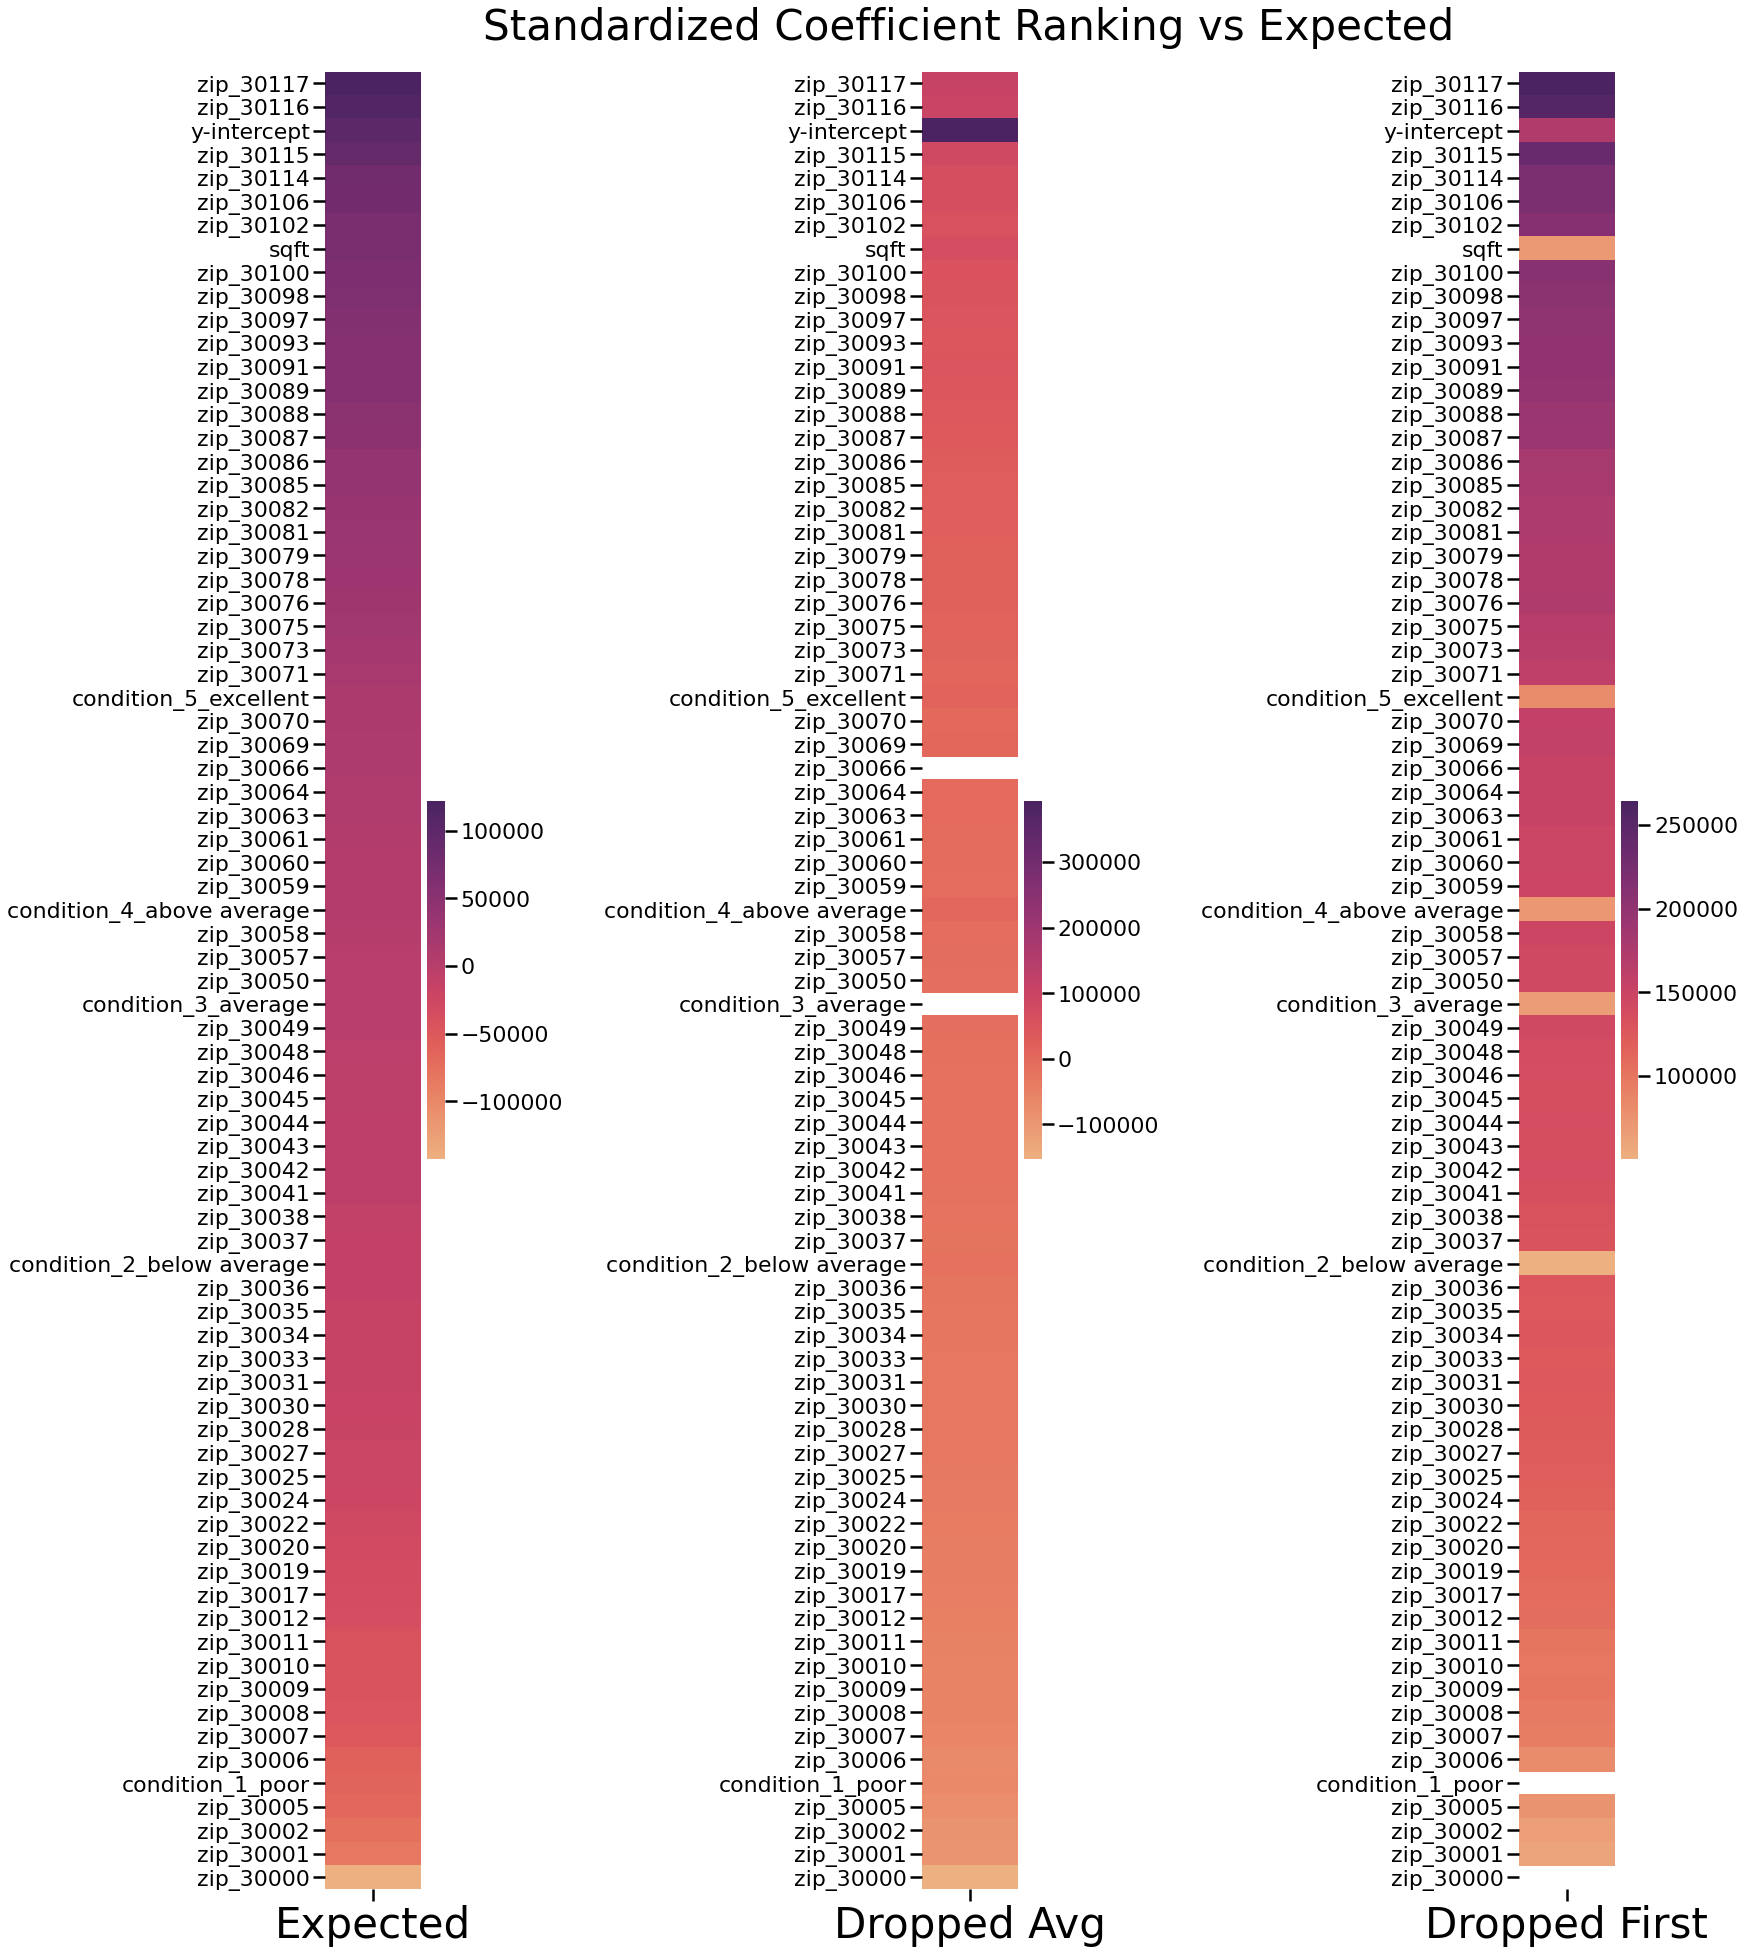

In [241]:
# do some renaming to make charts look nicer
std_test_coefs['Expected'] = df_ex_coefs_std['expected_coef']
#std_test_coefs.drop(index=['y-intercept'], inplace=True)
std_test_coefs = std_test_coefs.sort_values(['Expected'], ascending=False)

sns.set_context('poster')
    
fig, [ax1, ax2, ax3] = plt.subplots(figsize=(20, 30), ncols=3)
fig.tight_layout()
plt.subplots_adjust(wspace=4, hspace=2)

sns.heatmap(std_test_coefs[['Expected']], cmap='flare', ax=ax1)
sns.heatmap(std_test_coefs[['Dropped Avg']], cmap='flare', ax=ax2)
sns.heatmap(std_test_coefs[['Dropped First']], cmap='flare', ax=ax3)

for ax_f in [ax1, ax2, ax3]:
    ax_f.set_xticklabels(ax_f.get_xticklabels(), fontsize=42)

# great subplot title formatting tips used below from:
# https://stackoverflow.com/questions/7526625/matplotlib-global-legend-and-title-aside-subplots
st = fig.suptitle("Standardized Coefficient Ranking vs Expected", fontsize=42)
# shift subplots down:
st.set_y(0.90)
fig.subplots_adjust(top=0.87);

If we sort the variables (y-axis) for all three heatmaps to be the order of the expected coefficients, we can see that the color order for the Dropped Avg model is much closer to expected. 

In the Dropped First model, the Zip Codes and y-intercept are pretty close to what they should be; they follow the color order pretty well. But the Condition categories and Square Feet are way too low in the ranking; their colors do not blend into the gradient as they should.

In the Dropped Average model, the y-intercept is much higher than expected; it obviously sticks out of the color gradient. But the Zip Codes, Condition, and Square Feet look in pretty much the expected order.

It appears that the Dropped Avg model is more accurate with respect to the coefficients we would care about ranking, as opposed to the Dropped First model which is more accurate with respect to the y-intercept, which doesn't have much business meaning in this example.

Note that these heat maps haven't been told to share the same min/max values as expected, since we really only care about the order and not the values.

Let's zoom in on the condition categorical variables, since those seem to have the most discrepancy. 

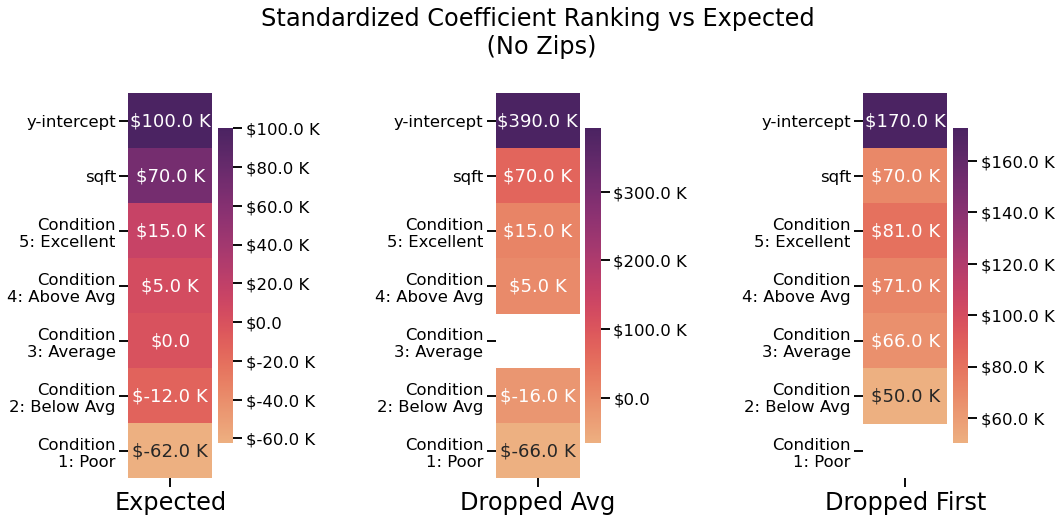

In [242]:
sns.set_context('talk')

mapper = {'condition_5_excellent': 'Condition\n5: Excellent',
          'condition_4_above average': 'Condition\n4: Above Avg',
          'condition_3_average': 'Condition\n3: Average',
          'condition_2_below average': 'Condition\n2: Below Avg',
          'condition_1_poor': 'Condition\n1: Poor',
         }

fig, [ax1, ax2, ax3] = plt.subplots(figsize=(13, 8), ncols=3)
fig.tight_layout()
plt.subplots_adjust(wspace=2.5)

exp = std_test_coefs.drop(index=test_coefs.filter(like='zip', axis=0).index)[['Expected']]
exp.rename(mapper=mapper, inplace=True)
avg = std_test_coefs.drop(index=test_coefs.filter(like='zip', axis=0).index)[['Dropped Avg']]
avg.rename(mapper=mapper, inplace=True)
first = std_test_coefs.drop(index=test_coefs.filter(like='zip', axis=0).index)[['Dropped First']]
first.rename(mapper=mapper, inplace=True)

sns.heatmap(exp, cmap='flare', ax=ax1, annot=True)
sns.heatmap(avg, cmap='flare', ax=ax2, annot=True)
sns.heatmap(first, cmap='flare', ax=ax3, annot=True)

# code adapted from https://stackoverflow.com/questions/55007525/add-comma-separator-to-seaborn-heatmap-using-set-text-from-matplotlib-and-keep-d
for ax_f in [ax1, ax2, ax3]:
    for t in ax_f.texts:
        t.set_text(linregtools.currency(float(t.get_text())))
    # code adapted from https://stackoverflow.com/questions/34820239/seaborn-heatmap-colorbar-label-as-percentage
    cbar = ax_f.collections[0].colorbar
    cbar.ax.yaxis.set_major_formatter(linregtools.currency)
    ax_f.set_yticklabels(ax_f.get_yticklabels(), rotation = 0)
    ax_f.set_xticklabels(ax_f.get_xticklabels(), fontsize=24)
    
# great subplot title formatting tips used below from:
# https://stackoverflow.com/questions/7526625/matplotlib-global-legend-and-title-aside-subplots
st = fig.suptitle("Standardized Coefficient Ranking vs Expected\n (No Zips)", fontsize=24)
# shift subplots down:
st.set_y(0.90)
fig.subplots_adjust(top=0.75);

If we take them out of the context of Zip Codes, it does look like the order of Condition categories matches expected for both models.

However, Square Feet should add about \\$55k more to Price than Condition Excellent. We see that this difference is pretty accurate in the Dropped Avg model, but in the Dropped First model, Condition Excellent is ranked above Square Feet.

If I were to use the standardized Dropped Average model to estimate which variables were more important to increasing price, I'd be pretty accurate.

But if I were to use the standardized Dropped First model to estimate this, I'd assume that Zip Codes were by and large the most important, followed by Condition Excellent, and then Square Feet. This would not be very accurate.

### Accurate Unstandardized Coefficients

We also might be interested in using the coefficients in original units, from the model where we did not standardize the data, to understand how the target variable changes per unit of each predictor variable. For instance, we would want to be able to use the coefficient associated with sq ft to say "for each sq ft, the price goes up by an estimated \\$100."


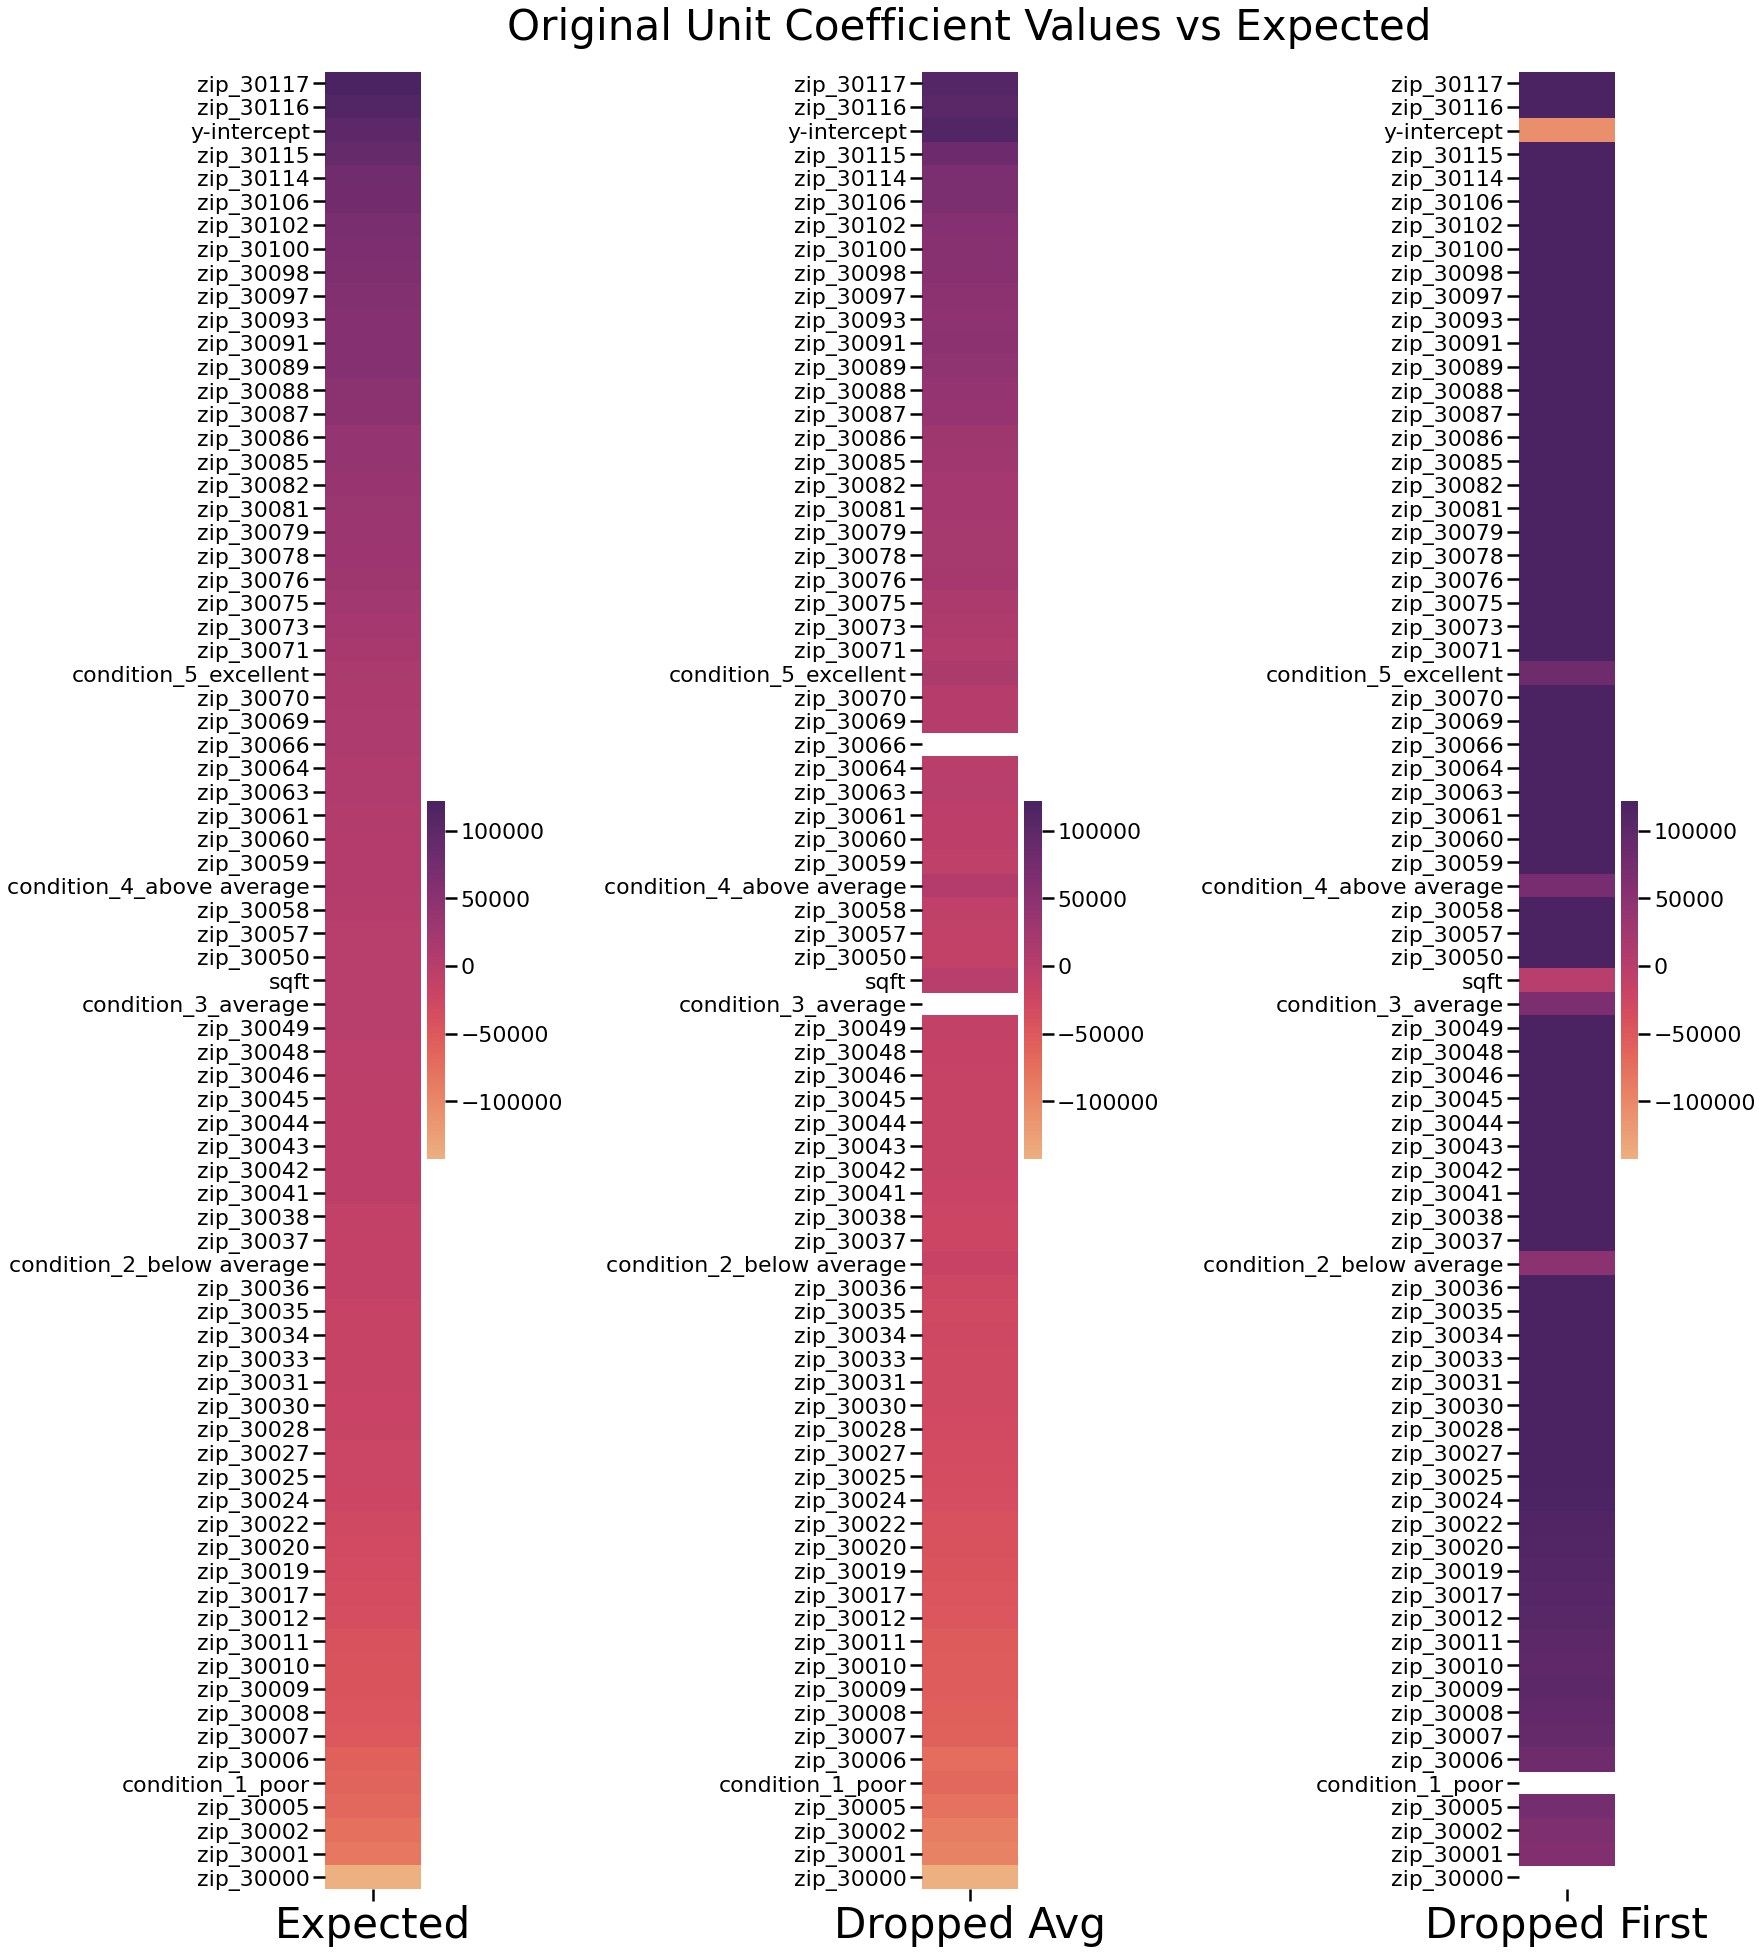

In [243]:
# filter out coefficients for models where we did NOT standardize data, and 
# did not include confounding variable (more realistic)
test_coefs = df_coefs.filter(items=[10, 11], axis=0).transpose()
test_coefs.rename(columns={10:'Dropped First', 11:'Dropped Avg'}, inplace=True)
test_coefs.drop(index='model_id', inplace=True)
test_coefs.dropna(axis=0, how='all', inplace=True)


test_coefs['Expected'] = df_ex_coefs['expected_coef']
test_coefs = test_coefs.sort_values(['Expected'], ascending=False)

sns.set_context('poster')
    
fig, [ax1, ax2, ax3] = plt.subplots(figsize=(20, 30), ncols=3)
fig.tight_layout()
plt.subplots_adjust(wspace=4)

# setting min and max values for each plot to follow the expected values, for
# ease of comparison
vmin = test_coefs[['Expected']].min()
vmax = test_coefs[['Expected']].max()

sns.heatmap(test_coefs[['Expected']], cmap='flare', ax=ax1, vmin=vmin, vmax=vmax)
sns.heatmap(test_coefs[['Dropped Avg']], cmap='flare', ax=ax2, vmin=vmin, vmax=vmax)
sns.heatmap(test_coefs[['Dropped First']], cmap='flare', ax=ax3, vmin=vmin, vmax=vmax)

for ax_f in [ax1, ax2, ax3]:
    ax_f.set_xticklabels(ax_f.get_xticklabels(), fontsize=42)

# great subplot title formatting tips used below from:
# https://stackoverflow.com/questions/7526625/matplotlib-global-legend-and-title-aside-subplots
st = fig.suptitle("Original Unit Coefficient Values vs Expected", fontsize=42)
# shift subplots down:
st.set_y(0.90)
fig.subplots_adjust(top=0.87);

Note that in this visualization, the color scale of the test models was forced to match the expected model, so we can compare the values by comparing the shades. Here we care about how accurate the coefficients are, as opposed to with standardized coefs, where we cared primarily about the ranking order.

We can see that the Dropped Avg model is much closer to expected coefficient values.

In the Dropped First model, the y-intercept was very low, which caused most of the other coefficients to be too high to make up for it.

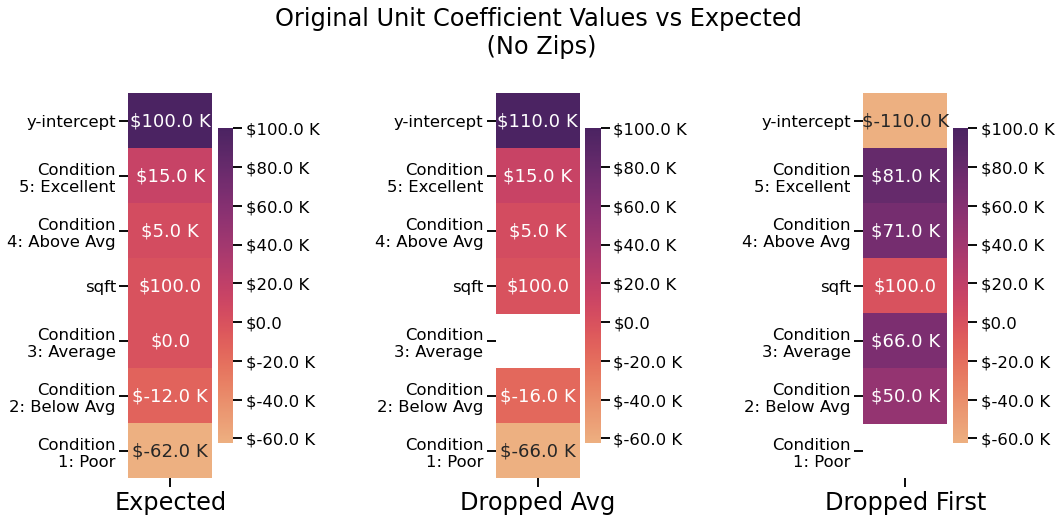

In [244]:
sns.set_context('talk')

mapper = {'condition_5_excellent': 'Condition\n5: Excellent',
          'condition_4_above average': 'Condition\n4: Above Avg',
          'condition_3_average': 'Condition\n3: Average',
          'condition_2_below average': 'Condition\n2: Below Avg',
          'condition_1_poor': 'Condition\n1: Poor',
         }

fig, [ax1, ax2, ax3] = plt.subplots(figsize=(13, 8), ncols=3)
fig.tight_layout()
plt.subplots_adjust(wspace=2.5)

exp2 = test_coefs.drop(index=test_coefs.filter(like='zip', axis=0).index)[['Expected']]
exp2.rename(mapper=mapper, inplace=True)
avg2 = test_coefs.drop(index=test_coefs.filter(like='zip', axis=0).index)[['Dropped Avg']]
avg2.rename(mapper=mapper, inplace=True)
first2 = test_coefs.drop(index=test_coefs.filter(like='zip', axis=0).index)[['Dropped First']]
first2.rename(mapper=mapper, inplace=True)

vmin = exp2.min()
vmax = exp2.max()

sns.heatmap(exp2, cmap='flare', ax=ax1, annot=True, vmin=vmin, vmax=vmax)
sns.heatmap(avg2, cmap='flare', ax=ax2, annot=True, vmin=vmin, vmax=vmax)
sns.heatmap(first2, cmap='flare', ax=ax3, annot=True, vmin=vmin, vmax=vmax)
    
# code adapted from https://stackoverflow.com/questions/55007525/add-comma-separator-to-seaborn-heatmap-using-set-text-from-matplotlib-and-keep-d
for ax_f in [ax1, ax2, ax3]:
    for t in ax_f.texts:
        t.set_text(linregtools.currency(float(t.get_text())))
    # code adapted from https://stackoverflow.com/questions/34820239/seaborn-heatmap-colorbar-label-as-percentage
    cbar = ax_f.collections[0].colorbar
    cbar.ax.yaxis.set_major_formatter(linregtools.currency)
    ax_f.set_yticklabels(ax_f.get_yticklabels(), rotation = 0)
    ax_f.set_xticklabels(ax_f.get_xticklabels(), fontsize=24)
    
# great subplot title formatting tips used below from:
# https://stackoverflow.com/questions/7526625/matplotlib-global-legend-and-title-aside-subplots
st = fig.suptitle("Original Unit Coefficient Values vs Expected\n (No Zips)", fontsize=24)
# shift subplots down:
st.set_y(0.90)
fig.subplots_adjust(top=0.75);
    


Let's take some more time to interpret these differences, as the fact that the Dropped First model's unit coefficients do not exactly match expected do not necessarily mean they are inherently wrong or not useful as-is.

First, let's notice that both test models have very accurate unit coefficients for Square Feet, our only continuous variable.

Next, we can see clearly that the Dropped Avg model has unit coefficients for Condition variables that very closely match expected, while the Dropped First model does not. But practically, what does this mean?

It's important to put these unit coefficients in the context of each model's baseline, or reference point. The coefficients must be interpreted with respect to this baseline.

For our continuous variable, Square Feet, the reference point was 0, and this would be the case for any continuous variables we included.

But for our categorical variables, the reference point for the baseline became whichever category column we dropped from the model. So we can say that:
>The differences in unit coefficients between the two test models is due to the models having different baselines for the categorical values.

Now it makes more sense why the coefficient for Square Feet is the same for both models, but the categorical coefficients differ: Square Feet assumed a baseline of 0 in both models.

The next logical question to ask is: **Is one baseline inherently better than the other?** To answer this question, let's consider how we would interpret the Condition unit coefficients for the Dropped First model, assuming we didn't know what was expected.

In the Dropped First mode, we dropped the Condition Poor column. So our baseline assumes a reference point of having the worst possible condition. We would interpret the coefficients like:

- Having a Condition of Below Average adds \\$50k to a house's baseline price
- Having a Condition of Average adds \\$66k to a house's baseline price
- Having a Condition of Above Average adds \\$71k to a house's baseline price
- Having a Condition of Excellent adds \\$81k to a house's baseline price

Whereas with the Dropped Avg model, the baseline assumes a condition of Average, so we would interpret the coefficients like:

- Having a Condition of Poor subtracts \\$66k from a house's baseline price
- Having a Condition of Below Average subtracts \\$16k from a house's baseline price
- Having a Condition of Above Average adds \\$5k to a house's baseline price
- Having a Condition of Excellent adds \\$15k to a house's baseline price

The steps between the coefficient values are the same in both models, but the positive/negative aspect is different.

One is not objectively better than the other. But if the goal of analysis is to provide actual coefficient values to non-technical stakeholders, dropping the average category for Condition yields the most intuitive coefficients that are most likely to make sense to stakeholders. 

Imagine the difficulty of explaining that although we have a positive number for the impact of Below Average Condition, this is within the context of a baseline house that actually has a negative price... it really doesn't make much sense.

# Summary of Findings

Although the category you choose to drop won't affect the model's prediction accuracy, it can have a significant impact on the interpretability of the model.

If you plan to use the coefficients in your model to make accurate inferences about:
- impact on the target per predictor unit,
- or the magnitude of impact each predictor has in relation to others,

then you should carefully consider which categorical values you drop from your model. 

A linear regression model's coefficients are interpreted in the context of a baseline model. For continuous variables, the baseline uses a reference point of 0. But **for categorical variables, whichever column is dropped becomes the reference point, which has a significant impact on how coefficients can be interpreted**.

It's important for data scientists to consider which columns represent the most intuitive reference points for each category, and drop those. Simply dropping the first column is arbitrary: the first column will not necessarily represent the minimum, and also the minimum does not necessarily always make a good reference point.

A thoughtful choice of which column to drop will yield coefficients that are much easier to interpret accurately.

## How should you choose which column to drop?

Instead of assuming that the first or minimum category value is the most appropriate, consider which category represents the most intuitive reference point for your stakeholders, or to help answer the questions at the root of your analysis.

For example, if you were modeling predictors of salary you might have a categorical predictor for level of schooling with the following values:

- Less than High School
- High School or GED
- Associate's degree
- Bachelor's degree
- Master's degree
- Doctorate degree

If you relied on the alpha-numeric first column, then *Associate's degree* would be your reference point. This could make sense if your stakeholders would be interested in how much people with less than an Associate's degree earn compared to people with higher than an Associate's degree.

But it could also be reasonable to use *High School or GED* as the reference point, if you felt that was a more accurate representation of the population's average education attainment. You could even figure out which of these categories seems to have a mean or median salary that most closely matches the mean or median of the population, to have a statistical reason to choose a particular category as the reference point.

And of course, if your primary goal is prediction, you don't have to worry about which category value you drop!